C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\gym\envs\classic_control\cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v0", render_mode="rgb_array")
  gym.logger.warn(
C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


E: 0.	Mean total reward across 5 rollouts: 14.0
E: 1.	Mean total reward across 5 rollouts: 18.0
E: 2.	Mean total reward across 5 rollouts: 15.0
E: 3.	Mean total reward across 5 rollouts: 51.0
E: 4.	Mean total reward across 5 rollouts: 82.0
E: 5.	Mean total reward across 5 rollouts: 48.0
E: 6.	Mean total reward across 5 rollouts: 10.0
E: 7.	Mean total reward across 5 rollouts: 9.0
E: 8.	Mean total reward across 5 rollouts: 15.0
E: 9.	Mean total reward across 5 rollouts: 11.0
E: 10.	Mean total reward across 5 rollouts: 38.0
E: 11.	Mean total reward across 5 rollouts: 39.0
E: 12.	Mean total reward across 5 rollouts: 18.0
E: 13.	Mean total reward across 5 rollouts: 27.0
E: 14.	Mean total reward across 5 rollouts: 38.0
E: 15.	Mean total reward across 5 rollouts: 17.0
E: 16.	Mean total reward across 5 rollouts: 33.0
E: 17.	Mean total reward across 5 rollouts: 52.0
E: 18.	Mean total reward across 5 rollouts: 14.0
E: 19.	Mean total reward across 5 rollouts: 87.0
E: 20.	Mean total reward across

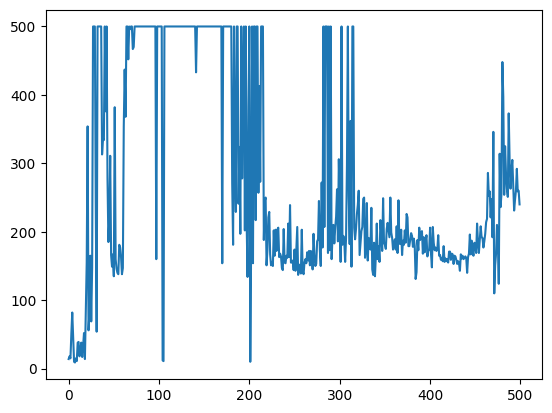

In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.distributions import Categorical
from collections import namedtuple

env = gym.make('CartPole-v0')

state_size = env.observation_space.shape[0]
num_actions = env.action_space.n

Rollout = namedtuple('Rollout', ['states', 'actions', 'rewards', 'next_states', ])


def train(actor, critic, epochs=100, num_rollouts=10, render_frequency=None):
    mean_total_rewards = []
    global_rollout = 0

    for epoch in range(epochs):
        rollouts = []
        

        for t in range(num_rollouts):
            state = env.reset()
            if type(state) == tuple:
                state = state[0]
                #print(state)
            done = False
            samples = []
            rollout_total_rewards = []
            steps = 0
            while not done and steps < 500:
                if render_frequency is not None and global_rollout % render_frequency == 0:
                    env.render()

                with torch.no_grad():
                    action = get_action(state)

                next_state, reward, done, info, _ = env.step(action)

                # Collect samples
                samples.append((state, action, reward, next_state))

                state = next_state
                steps += 1

            # Transpose our samples
            states, actions, rewards, next_states = zip(*samples)
            #print(states)
            states = torch.stack([torch.from_numpy(state) for state in states], dim=0).float()
            next_states = torch.stack([torch.from_numpy(state) for state in next_states], dim=0).float()
            actions = torch.as_tensor(actions).unsqueeze(1)
            rewards = torch.as_tensor(rewards).unsqueeze(1)

            rollouts.append(Rollout(states, actions, rewards, next_states))

            rollout_total_rewards.append(rewards.sum().item())
            global_rollout += 1

        update_agent(rollouts)
        mtr = np.mean(rollout_total_rewards)
        print(f'E: {epoch}.\tMean total reward across {num_rollouts} rollouts: {mtr}')

        mean_total_rewards.append(mtr)

    plt.plot(mean_total_rewards)
    plt.show()
    return mean_total_rewards


def create_actor(state_size, action_size, hidden_size=32):
    actor_model = nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, action_size),
        nn.Softmax(dim=-1)
    )
    return actor_model

# Create critic model
def create_critic(state_size, hidden_size=32):
    critic_model = nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 1)
    )
    return critic_model

actor_hidden = 32
'''
actor = nn.Sequential(nn.Linear(state_size, actor_hidden),
                      nn.ReLU(),
                      nn.Linear(actor_hidden, num_actions),
                      nn.Softmax(dim = -1))
'''

def get_action(state):
    if type(state) == tuple:
        print(state)
        state = state[0]
    state = torch.tensor(state).float().unsqueeze(0)  # Turn state into a batch with a single element
    dist = Categorical(actor(state) /10)  # Create a distribution from probabilities for actions
    return dist.sample().item()


# Critic takes a state and returns its values
critic_hidden = 32
'''
critic = nn.Sequential(nn.Linear(state_size, critic_hidden),
                       nn.ReLU(),
                       nn.Linear(critic_hidden, 1))
critic_optimizer = Adam(critic.parameters(), lr=0.01)
'''

def update_critic(advantages):
    loss = .5 * (advantages ** 2).mean()  # MSE
    critic_optimizer.zero_grad()
    loss.backward()
    critic_optimizer.step()


# delta, maximum KL divergence
max_d_kl = 0.01


def update_agent(rollouts):
    states = torch.cat([r.states for r in rollouts], dim=0)
    actions = torch.cat([r.actions for r in rollouts], dim=0).flatten()

    advantages = [estimate_advantages(states, next_states[-1], rewards) for states, _, rewards, next_states in rollouts]
    advantages = torch.cat(advantages, dim=0).flatten()

    # Normalize advantages to reduce skewness and improve convergence
    advantages = (advantages - advantages.mean()) / advantages.std()

    update_critic(advantages)

    distribution = actor(states)
    distribution = torch.distributions.utils.clamp_probs(distribution)
    probabilities = distribution[range(distribution.shape[0]), actions]

    # Now we have all the data we need for the algorithm

    # We will calculate the gradient wrt to the new probabilities (surrogate function),
    # so second probabilities should be treated as a constant
    L = surrogate_loss(probabilities, probabilities.detach(), advantages) 
    KL = kl_div(distribution, distribution)

    parameters = list(actor.parameters())

    g = flat_grad(L, parameters, retain_graph=True)
    d_kl = flat_grad(KL, parameters, create_graph=True)  # Create graph, because we will call backward() on it (for HVP)

    def HVP(v):
        return flat_grad(d_kl @ v, parameters, retain_graph=True)

    search_dir = conjugate_gradient(HVP, g)
    max_length = torch.sqrt(2 * max_d_kl / (search_dir @ HVP(search_dir)))
    max_step = max_length * search_dir

    def criterion(step):
        apply_update(step)

        with torch.no_grad():
            distribution_new = actor(states)
            distribution_new = torch.distributions.utils.clamp_probs(distribution_new)
            probabilities_new = distribution_new[range(distribution_new.shape[0]), actions]

            L_new = surrogate_loss(probabilities_new, probabilities, advantages)
            KL_new = kl_div(distribution, distribution_new)

        L_improvement = L_new - L

        if L_improvement > 0 and KL_new <= max_d_kl:
            return True

        apply_update(-step)
        return False

    i = 0
    while not criterion((0.9 ** i) * max_step) and i < 10:
        i += 1


def estimate_advantages(states, last_state, rewards):
    values = critic(states)
    last_value = critic(last_state.unsqueeze(0))
    next_values = torch.zeros_like(rewards)
    for i in reversed(range(rewards.shape[0])):
        last_value = next_values[i] = rewards[i] + 0.99 * last_value
    advantages = next_values - values
    return advantages


def surrogate_loss(new_probabilities, old_probabilities, advantages):
    return (new_probabilities / old_probabilities * advantages).mean()


def kl_div(p, q):
    p = p.detach()
    return (p * (p.log() - q.log())).sum(-1).mean()


def flat_grad(y, x, retain_graph=False, create_graph=False):
    if create_graph:
        retain_graph = True

    g = torch.autograd.grad(y, x, retain_graph=retain_graph, create_graph=create_graph)
    g = torch.cat([t.view(-1) for t in g])
    return g


def conjugate_gradient(A, b, delta=0., max_iterations=10):
    x = torch.zeros_like(b)
    r = b.clone()
    p = b.clone()

    i = 0
    while i < max_iterations:
        AVP = A(p)

        dot_old = r @ r
        alpha = dot_old / (p @ AVP)

        x_new = x + alpha * p

        if (x - x_new).norm() <= delta:
            return x_new

        i += 1
        r = r - alpha * AVP

        beta = (r @ r) / dot_old
        p = r + beta * p

        x = x_new
    return x


def apply_update(grad_flattened):
    n = 0
    for p in actor.parameters():
        numel = p.numel()
        g = grad_flattened[n:n + numel].view(p.shape)
        p.data += g
        n += numel

#a = train(epochs=500, num_rollouts=5, render_frequency=50)

# Train our agent
trials = 3
results = []

actor = create_actor(state_size, num_actions)
critic = create_critic(state_size)
critic_optimizer = Adam(critic.parameters(), lr=0.01)
results.append(train(actor, critic, epochs=500, num_rollouts=5, render_frequency=50))




C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\gym\envs\classic_control\cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v0", render_mode="rgb_array")
  gym.logger.warn(


E: 0.	Mean total reward across 5 rollouts: 13.0
E: 1.	Mean total reward across 5 rollouts: 19.0
E: 2.	Mean total reward across 5 rollouts: 10.0
E: 3.	Mean total reward across 5 rollouts: 10.0
E: 4.	Mean total reward across 5 rollouts: 9.0
E: 5.	Mean total reward across 5 rollouts: 14.0
E: 6.	Mean total reward across 5 rollouts: 27.0
E: 7.	Mean total reward across 5 rollouts: 17.0
E: 8.	Mean total reward across 5 rollouts: 21.0
E: 9.	Mean total reward across 5 rollouts: 30.0
E: 10.	Mean total reward across 5 rollouts: 36.0
E: 11.	Mean total reward across 5 rollouts: 19.0
E: 12.	Mean total reward across 5 rollouts: 54.0
E: 13.	Mean total reward across 5 rollouts: 37.0
E: 14.	Mean total reward across 5 rollouts: 54.0
E: 15.	Mean total reward across 5 rollouts: 30.0
E: 16.	Mean total reward across 5 rollouts: 26.0
E: 17.	Mean total reward across 5 rollouts: 23.0
E: 18.	Mean total reward across 5 rollouts: 208.0
E: 19.	Mean total reward across 5 rollouts: 170.0
E: 20.	Mean total reward acro

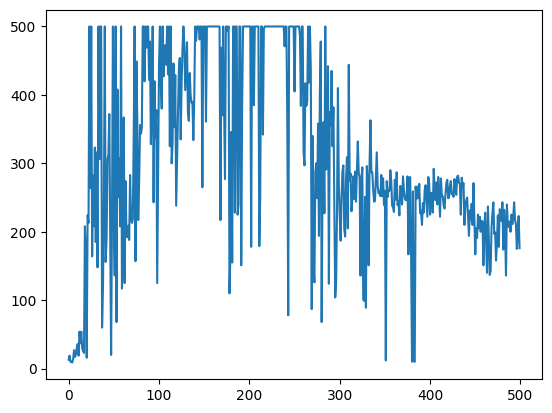

E: 0.	Mean total reward across 5 rollouts: 17.0
E: 1.	Mean total reward across 5 rollouts: 14.0
E: 2.	Mean total reward across 5 rollouts: 19.0
E: 3.	Mean total reward across 5 rollouts: 14.0
E: 4.	Mean total reward across 5 rollouts: 13.0
E: 5.	Mean total reward across 5 rollouts: 34.0
E: 6.	Mean total reward across 5 rollouts: 13.0
E: 7.	Mean total reward across 5 rollouts: 17.0
E: 8.	Mean total reward across 5 rollouts: 17.0
E: 9.	Mean total reward across 5 rollouts: 90.0
E: 10.	Mean total reward across 5 rollouts: 30.0
E: 11.	Mean total reward across 5 rollouts: 21.0
E: 12.	Mean total reward across 5 rollouts: 16.0
E: 13.	Mean total reward across 5 rollouts: 29.0
E: 14.	Mean total reward across 5 rollouts: 66.0
E: 15.	Mean total reward across 5 rollouts: 13.0
E: 16.	Mean total reward across 5 rollouts: 133.0
E: 17.	Mean total reward across 5 rollouts: 267.0
E: 18.	Mean total reward across 5 rollouts: 134.0
E: 19.	Mean total reward across 5 rollouts: 132.0
E: 20.	Mean total reward a

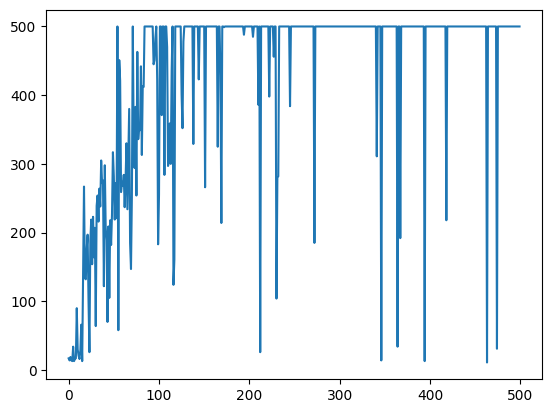

E: 0.	Mean total reward across 5 rollouts: 28.0
E: 1.	Mean total reward across 5 rollouts: 12.0
E: 2.	Mean total reward across 5 rollouts: 29.0
E: 3.	Mean total reward across 5 rollouts: 32.0
E: 4.	Mean total reward across 5 rollouts: 11.0
E: 5.	Mean total reward across 5 rollouts: 11.0
E: 6.	Mean total reward across 5 rollouts: 10.0
E: 7.	Mean total reward across 5 rollouts: 11.0
E: 8.	Mean total reward across 5 rollouts: 20.0
E: 9.	Mean total reward across 5 rollouts: 11.0
E: 10.	Mean total reward across 5 rollouts: 10.0
E: 11.	Mean total reward across 5 rollouts: 46.0
E: 12.	Mean total reward across 5 rollouts: 55.0
E: 13.	Mean total reward across 5 rollouts: 41.0
E: 14.	Mean total reward across 5 rollouts: 19.0
E: 15.	Mean total reward across 5 rollouts: 69.0
E: 16.	Mean total reward across 5 rollouts: 124.0
E: 17.	Mean total reward across 5 rollouts: 99.0
E: 18.	Mean total reward across 5 rollouts: 98.0
E: 19.	Mean total reward across 5 rollouts: 174.0
E: 20.	Mean total reward acr

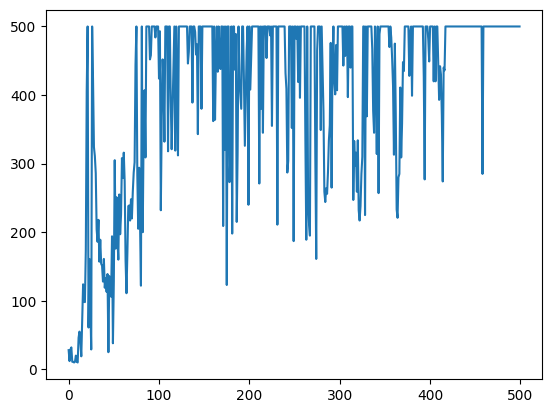

E: 0.	Mean total reward across 5 rollouts: 9.0
E: 1.	Mean total reward across 5 rollouts: 27.0
E: 2.	Mean total reward across 5 rollouts: 17.0
E: 3.	Mean total reward across 5 rollouts: 37.0
E: 4.	Mean total reward across 5 rollouts: 15.0
E: 5.	Mean total reward across 5 rollouts: 54.0
E: 6.	Mean total reward across 5 rollouts: 20.0
E: 7.	Mean total reward across 5 rollouts: 18.0
E: 8.	Mean total reward across 5 rollouts: 11.0
E: 9.	Mean total reward across 5 rollouts: 64.0
E: 10.	Mean total reward across 5 rollouts: 70.0
E: 11.	Mean total reward across 5 rollouts: 46.0
E: 12.	Mean total reward across 5 rollouts: 83.0
E: 13.	Mean total reward across 5 rollouts: 44.0
E: 14.	Mean total reward across 5 rollouts: 124.0
E: 15.	Mean total reward across 5 rollouts: 20.0
E: 16.	Mean total reward across 5 rollouts: 23.0
E: 17.	Mean total reward across 5 rollouts: 326.0
E: 18.	Mean total reward across 5 rollouts: 94.0
E: 19.	Mean total reward across 5 rollouts: 188.0
E: 20.	Mean total reward acr

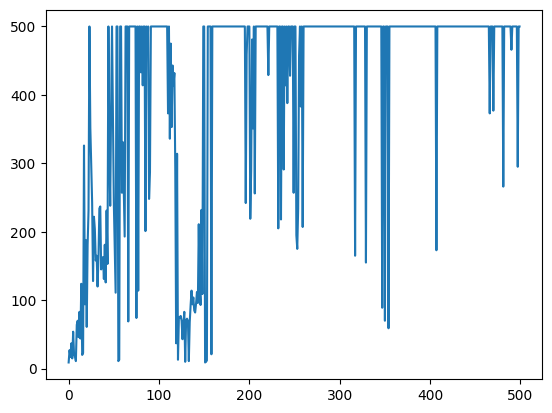

E: 0.	Mean total reward across 5 rollouts: 16.0
E: 1.	Mean total reward across 5 rollouts: 36.0
E: 2.	Mean total reward across 5 rollouts: 23.0
E: 3.	Mean total reward across 5 rollouts: 16.0
E: 4.	Mean total reward across 5 rollouts: 15.0
E: 5.	Mean total reward across 5 rollouts: 42.0
E: 6.	Mean total reward across 5 rollouts: 38.0
E: 7.	Mean total reward across 5 rollouts: 57.0
E: 8.	Mean total reward across 5 rollouts: 106.0
E: 9.	Mean total reward across 5 rollouts: 58.0
E: 10.	Mean total reward across 5 rollouts: 47.0
E: 11.	Mean total reward across 5 rollouts: 29.0
E: 12.	Mean total reward across 5 rollouts: 67.0
E: 13.	Mean total reward across 5 rollouts: 115.0
E: 14.	Mean total reward across 5 rollouts: 80.0
E: 15.	Mean total reward across 5 rollouts: 273.0
E: 16.	Mean total reward across 5 rollouts: 207.0
E: 17.	Mean total reward across 5 rollouts: 237.0
E: 18.	Mean total reward across 5 rollouts: 117.0
E: 19.	Mean total reward across 5 rollouts: 149.0
E: 20.	Mean total rewar

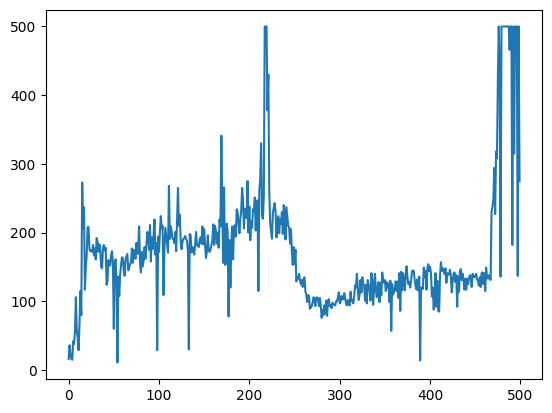

In [4]:
for i in range(5):
    actor = create_actor(state_size, num_actions)
    critic = create_critic(state_size)
    critic_optimizer = Adam(critic.parameters(), lr=0.01)
    results.append(train(actor, critic, epochs=500, num_rollouts=5, render_frequency=50))

[[14.0, 18.0, 15.0, 51.0, 82.0, 48.0, 10.0, 9.0, 15.0, 11.0, 38.0, 39.0, 18.0, 27.0, 38.0, 17.0, 33.0, 52.0, 14.0, 87.0, 155.0, 354.0, 56.0, 83.0, 165.0, 69.0, 148.0, 500.0, 500.0, 500.0, 242.0, 54.0, 500.0, 500.0, 500.0, 500.0, 500.0, 313.0, 336.0, 334.0, 500.0, 376.0, 500.0, 278.0, 185.0, 218.0, 311.0, 166.0, 149.0, 167.0, 135.0, 382.0, 160.0, 146.0, 140.0, 138.0, 181.0, 177.0, 163.0, 138.0, 147.0, 354.0, 437.0, 368.0, 500.0, 500.0, 452.0, 500.0, 496.0, 500.0, 500.0, 467.0, 470.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 160.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 12.0, 11.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 433.0, 500.0, 500.0, 500.0, 500.0, 500

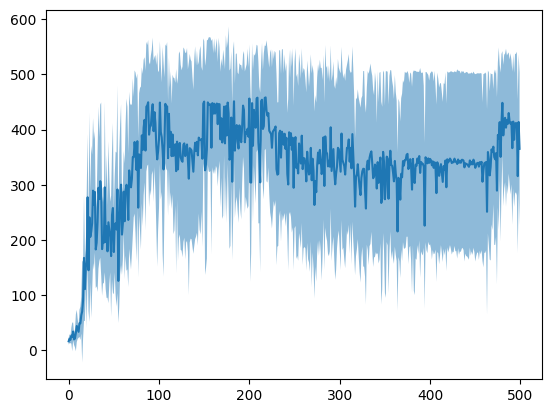

In [6]:
print(results)
mean = np.mean(results, axis = 0)
std = np.std(results, axis = 0)
plt.plot(mean)
plt.fill_between(range(500), mean-std, mean+std, alpha = 0.5)

In [7]:
import pickle
dataStore = {}

dataStore['TRPO'] = results
    
with open('./' + 'Results_TRPO_CP' + '.pkl', 'wb') as fp:
        pickle.dump(dataStore, fp)
        print('dictionary saved successfully to file')

dictionary saved successfully to file
